# Make a SchNetPack-Compatible Database
Generate a new training set with the inferred atomic coordinates

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jcesr_ml.coordinates import generate_atomic_coordinates, generate_conformers
from jcesr_ml.schnetpack import make_schnetpack_data
from jcesr_ml.benchmark import load_benchmark_data
from multiprocessing import Pool, TimeoutError
from tqdm import tqdm_notebook as tqdm
from ase.io.xyz import read_xyz
from io import StringIO
import pickle as pkl
import pandas as pd
import numpy as np

## Get Data
We need the training set with the new coordinates

In [2]:
train_data, _ = load_benchmark_data()

Get the properties to be stored in the database

In [3]:
properties = ['g4mp2_0k', 'u0', 'homo', 'lumo', 'zpe', 'atomic_charges']

## Generate Atomic Coordinates
Use the utility we constructed with OpenBabel

In [4]:
%%time
with Pool() as p:
    train_data['xyz_gen'] = p.map(generate_atomic_coordinates, tqdm(train_data['smiles_0']), 64)

HBox(children=(IntProgress(value=0, max=117232), HTML(value='')))


CPU times: user 2.39 s, sys: 1.3 s, total: 3.69 s
Wall time: 13h 6min 54s


## Generate Conformers
Generate conformers for each molecule using the GA-based method in OpenBabel

In [5]:
timeout = 15 # Normally, calculations take less than 1s. Some or kill the Python process

In [6]:
%%time
with Pool() as p:
    futures = [p.apply_async(generate_conformers, (x,)) for x in train_data['xyz_gen']]
    
    # Wait for all to finish
    conformers = []
    failures = 0
    for x, y in tqdm(zip(futures, train_data['xyz_gen'])):
        try:
            res = x.get(timeout)
        except TimeoutError:
            failures += 1
            res = [y]
        conformers.append(res)
        
    # Add to dataframe
    train_data['conformers'] = conformers
    print('Number of failures:', failures)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))


Number of failures: 2
CPU times: user 30.4 s, sys: 27 s, total: 57.4 s
Wall time: 1h 39min 43s


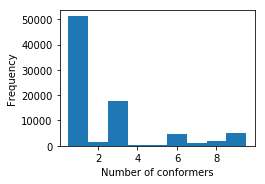

In [7]:
fig, ax = plt.subplots()

n_conf = train_data['conformers'].apply(len)
bins = np.arange(0.5, n_conf.max())
ax.hist(n_conf, bins)

ax.set_xlabel('Number of conformers')
ax.set_ylabel('Frequency')

fig.set_size_inches(3.5, 2.5)

## Make an ASE Database
The current version of SchNetPack relies on storing data in an ASE SQLite database. We must convert our data into that format

In [8]:
db = make_schnetpack_data(train_data, 'train_dataset.db', properties=properties,
                          xyz_col='xyz_gen', conformers='conformers')
with open('train_dataset.pkl', 'wb') as fp:
    pkl.dump(db, fp)